In [96]:
import tensorflow as tf
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

warnings.filterwarnings('ignore')
%matplotlib inline

In [97]:


# Comments for documentation:
# - `import tensorflow as tf`: Import TensorFlow for building and training machine learning models.
# - `import os`: Import os module to interact with the operating system, e.g., reading file paths.
# - `import pandas as pd`: Import pandas for data manipulation and analysis.
# - `import numpy as np`: Import NumPy for numerical operations on arrays and matrices.
# - `import matplotlib as plt`: Import matplotlib for creating static, interactive, and animated visualizations in Python.
# - `from sklearn.metrics import mean_squared_error as mse`: Import mean_squared_error from sklearn for calculating the MSE metric for model evaluation.
# - `from sklearn.preprocessing import MinMaxScaler`: Import MinMaxScaler from sklearn for feature scaling by normalizing or standardizing features.
# - `import warnings`: Import warnings module to suppress warnings.
# - `import matplotlib.pyplot as plt`: Import pyplot from matplotlib for plotting graphs.
# - `warnings.filterwarnings('ignore')`: Set up warnings to ignore them to avoid clutter in the output.
# - `%matplotlib inline`: Enable inline plotting for Jupyter notebooks, making plots appear in the notebook itself.


In [98]:
class ResBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size, dilation_rate):
        super(ResBlock, self).__init__()
        
        self.conv1 = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        
        self.conv2 = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)
        self.bn2 = BatchNormalization()
        
    def call(self, inputs):
        residual = inputs
        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        x = Add()([x, residual])  # Add the residual connection
        x = Activation('relu')(x)
        
        return x

def create_LSTMTCN_model():
    inputs = Input(shape=(5, 7))  # Input shape (window size, features)
    
    x = Dense(256)(inputs)  # Fully connected to expand dimensions
    
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(128, return_sequences=True)(x)  # Keep returning sequences for ResBlock
    
    # Adding Residual Blocks
    x = ResBlock(128, kernel_size=3, dilation_rate=1)(x)
    x = ResBlock(128, kernel_size=3, dilation_rate=2)(x)
    x = ResBlock(128, kernel_size=3, dilation_rate=4)(x)

    outputs = Dense(1)(x)  # Final output layer

    model = Model(inputs, outputs)
    return model

# model = LSTMTCN()
# model.compile(optimizer='adam', loss='mse')

# model.fit(X_train, y_train, epochs=10, batch_size=32)
# X_test, y_test = get_test_data()
# predictions = model.predict(X_test)

In [99]:
df = pd.read_csv('timeseries.csv')
season = {'Winter':1,'Spring':2,'Summer':3,'Autumn':4}

In [100]:
df = df[:96431:]
df.index = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
df['G(i)'] = pd.to_numeric(df['G(i)'], errors='coerce')

day  = 60 * 60 * 24
year =  365.2425 * day
month = 30 * day

df["Seconds"] = df.index.map(pd.Timestamp.timestamp)
df ["day sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /day))
df ["day cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /day))
# df ["year sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /year))
# df ["year cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /year))

# 1971
df = df.drop(["Seconds"], axis = 1)

# Check for any NaN values after conversion
# print("NaN values in G(i):", df['G(i)'].isna().sum())
df= df[df['G(i)'] > 10]

def get_season(month):
    if month in [12, 1, 2]:
        return season['Winter']
    elif month in [3, 4, 5]:
        return season['Spring']
    elif month in [6, 7, 8]:
        return season['Summer']
    elif month in [9, 10, 11]:
        return season['Autumn']

# Apply the function to create the season column
df['Season'] = df.index.month.map(get_season)

# Load data into DataFrame
data = df.copy()
data.drop(['Int'], axis = 1,inplace=True)

# Ensure 'time' column is of string type
data['time'] = data['time'].astype(str)

# Validate 'time' column format and filter rows with valid datetime-like strings
valid_time_format = r'^\d{8}:\d{4}$'
data = data[data['time'].str.match(valid_time_format, na=False)]

# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'], format='%Y%m%d:%H%M')

# Set 'time' as the index
data.set_index('time', inplace=True)

# Convert all columns to numeric, coercing errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling with the mean of each column
data.fillna(data.mean(), inplace=True)

# print(data.describe())

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit and transform the data
scaled_data = scaler.fit_transform(data)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Display the first few rows and basic statistics to confirm
# print(scaled_df.head())


print(scaled_df.head(15))
data=scaled_df


                         G(i)     H_sun       T2m     WS10m   day sin  \
time                                                                    
2010-01-01 04:07:00  0.071332  0.006303  0.124001  0.317957  0.931337   
2010-01-01 05:07:00  0.369032  0.159829  0.183397  0.283361  0.984864   
2010-01-01 06:07:00  0.586913  0.304317  0.320250  0.283361  1.000000   
2010-01-01 07:07:00  0.749934  0.433107  0.449114  0.283361  0.975715   
2010-01-01 08:07:00  0.854851  0.534190  0.516846  0.273476  0.913663   
2010-01-01 09:07:00  0.895757  0.588417  0.553317  0.204283  0.818074   
2010-01-01 10:07:00  0.864754  0.578904  0.595693  0.125206  0.695461   
2010-01-01 11:07:00  0.766906  0.509335  0.616534  0.046129  0.554181   
2010-01-01 12:07:00  0.605511  0.398621  0.623480  0.034596  0.403861   
2010-01-01 13:07:00  0.404155  0.264479  0.613407  0.079077  0.254745   
2010-01-01 14:07:00  0.173677  0.116899  0.589788  0.102142  0.116995   
2010-01-02 04:07:00  0.006421  0.005470  0.146231  

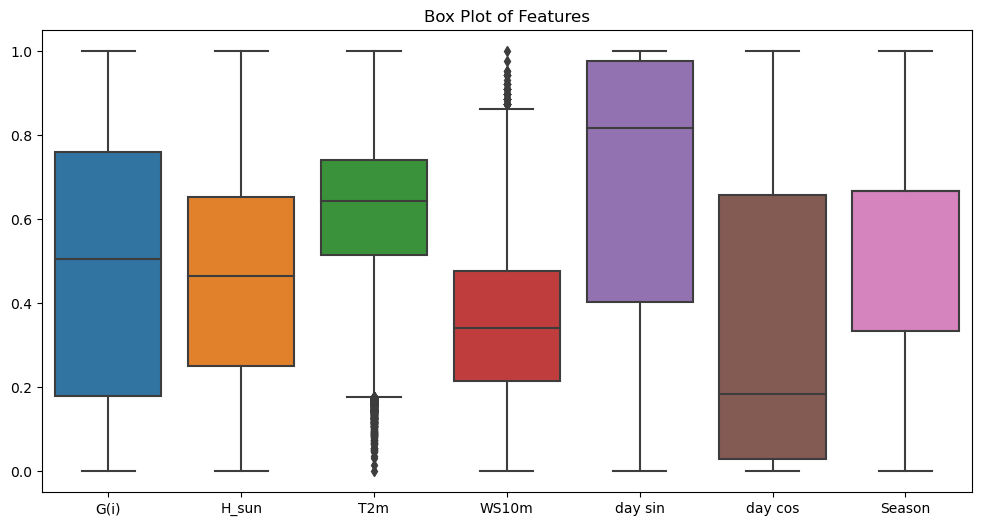

In [101]:
# Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)
plt.title('Box Plot of Features')
plt.show()

                         G(i)     H_sun       T2m     WS10m   day sin  \
time                                                                    
2010-01-01 04:00:00  0.071332  0.006303  0.124001  0.317957  0.931337   
2010-01-01 05:00:00  0.369032  0.159829  0.183397  0.283361  0.984864   
2010-01-01 06:00:00  0.586913  0.304317  0.320250  0.283361  1.000000   
2010-01-01 07:00:00  0.749934  0.433107  0.449114  0.283361  0.975715   
2010-01-01 08:00:00  0.854851  0.534190  0.516846  0.273476  0.913663   
2010-01-01 09:00:00  0.895757  0.588417  0.553317  0.204283  0.818074   
2010-01-01 10:00:00  0.864754  0.578904  0.595693  0.125206  0.695461   
2010-01-01 11:00:00  0.766906  0.509335  0.616534  0.046129  0.554181   
2010-01-01 12:00:00  0.605511  0.398621  0.623480  0.034596  0.403861   
2010-01-01 13:00:00  0.404155  0.264479  0.613407  0.079077  0.254745   

                          day cos  Season  
time                                       
2010-01-01 04:00:00  1.000000e+00  

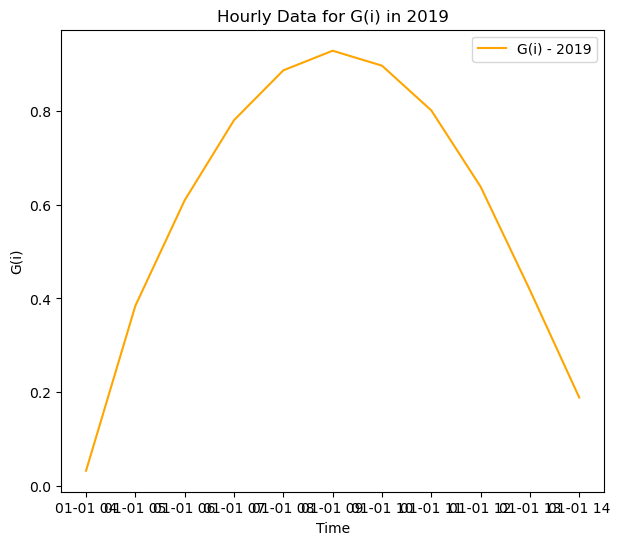

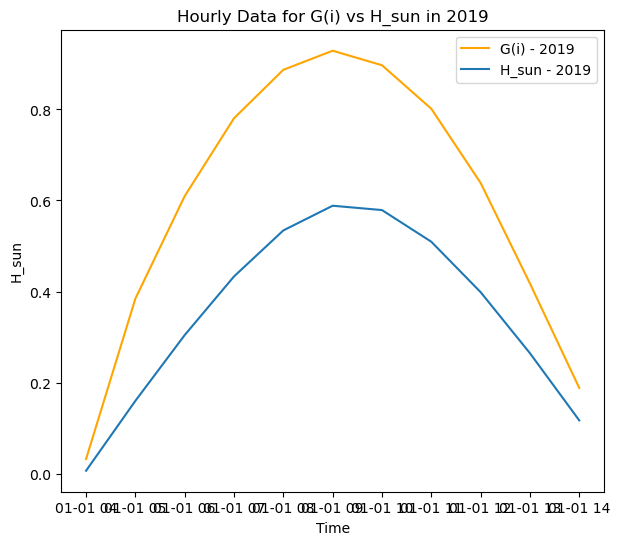

In [102]:
# TODO Merhawi
# this for hourly basis
# Now resample to hourly intervals
# data_hourly = data.resample('H').mean()

# Verify index is DatetimeIndex
print(data_hourly.head(10))

# Continue with plotting code as before
# Get unique years in the dataset
#years = data_hourly.index.year.unique()



data_2019 = data_hourly[(data_hourly.index.year == 2019) & (data_hourly.index.month == 1) &
                        (data_hourly.index.day == 1)]
print(data_2019)

# this is plot for G (i) vesrus wiht h_sun
plt.figure(figsize=(7,6))
plt.plot(data_2019.index, data_2019['G(i)'], color='orange', label='G(i) - 2019')
plt.title('Hourly Data for G(i) in 2019')
plt.xlabel('Time')
plt.ylabel('G(i)')
plt.legend()
plt.show()
    

plt.figure(figsize=(7, 6))
plt.plot(data_2019.index, data_2019['G(i)'], color='orange', label='G(i) - 2019')
plt.plot(data_2019.index, data_2019['H_sun'], label='H_sun - 2019')
plt.title('Hourly Data for G(i) vs H_sun in 2019')
plt.xlabel('Time')
plt.ylabel('H_sun')
plt.legend()
plt.show()

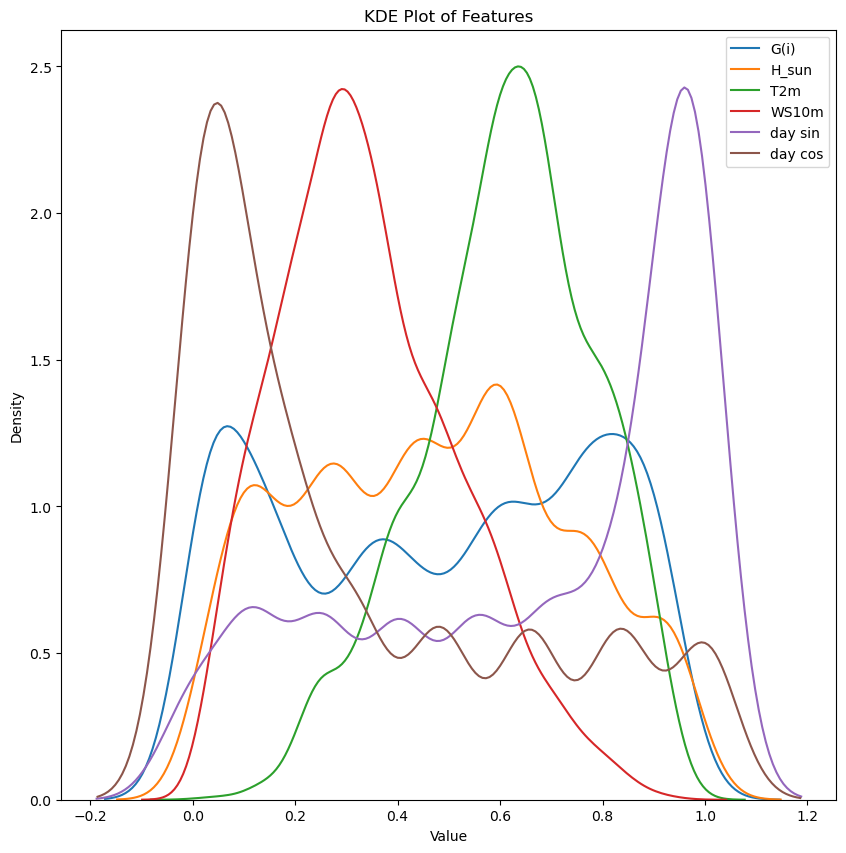

In [103]:
data.drop(['Season'], axis=1, inplace=True)
data_2019 = data[(data.index.year == 2019)]
# Additional KDE Plot for each feature to observe distribution
plt.figure(figsize=(10, 10))
for column in data_2019.columns:
    sns.kdeplot(data_2019[column] , label=column)
plt.title('KDE Plot of Features')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


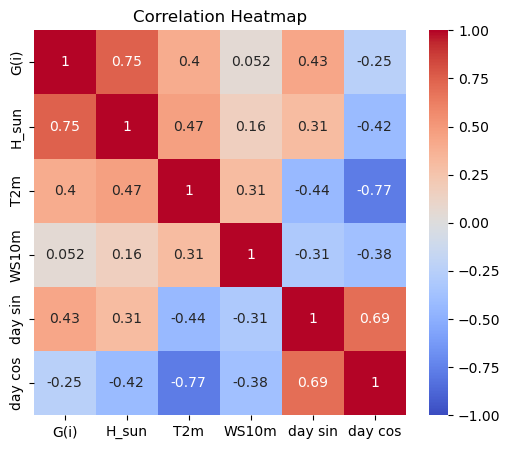

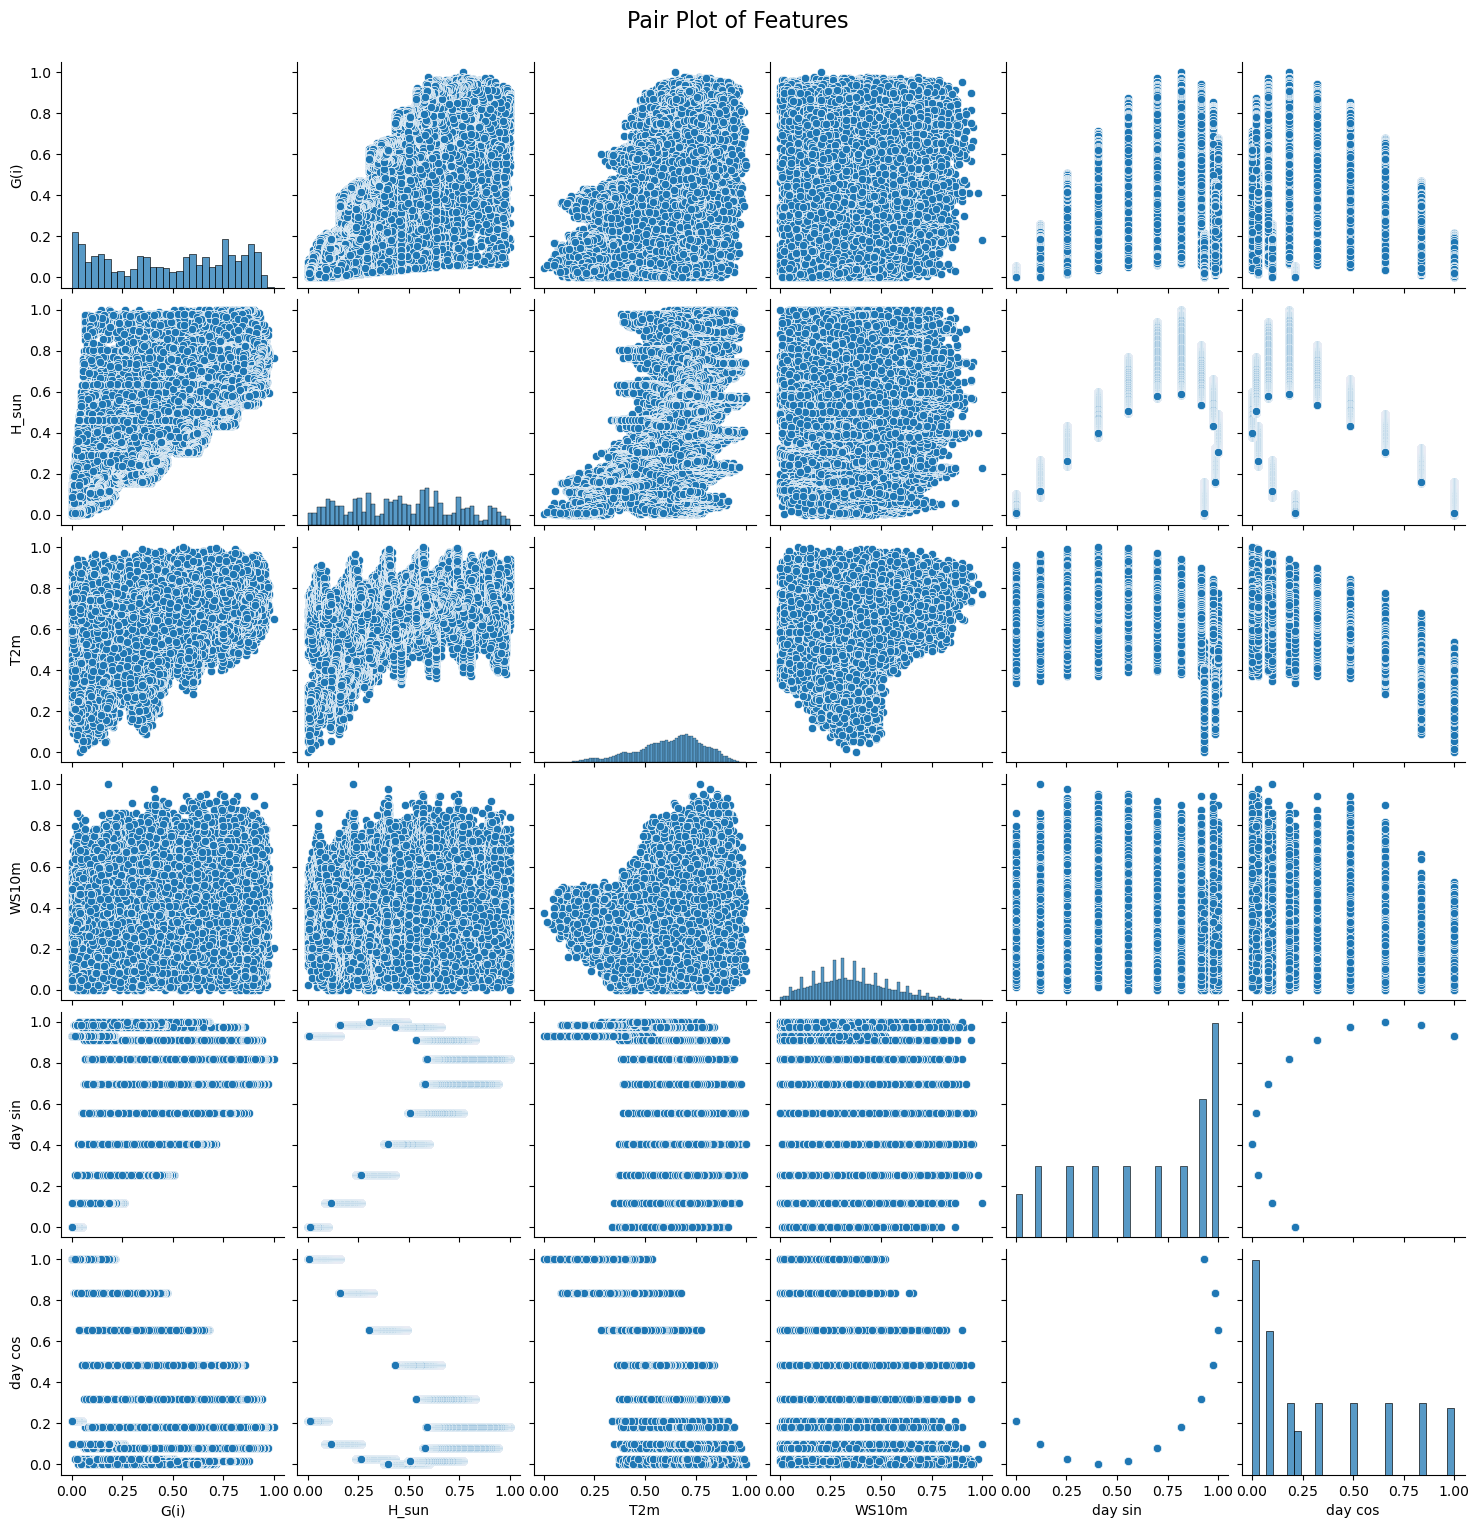

In [104]:
 ## Correlation Analysis
# Correlation Heatmap
plt.figure(figsize=(6, 5))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Pair Plot for Visualizing Relationships Between Features
sns.pairplot(data, palette='bright')
plt.suptitle('Pair Plot of Features', y=1.02, fontsize=16)
plt.show()


In [105]:
df = df.dropna(subset=['time']) 
df['time'].tail(20)

time
2020-12-30 06:07:00    20201230:0607
2020-12-30 07:07:00    20201230:0707
2020-12-30 08:07:00    20201230:0807
2020-12-30 09:07:00    20201230:0907
2020-12-30 10:07:00    20201230:1007
2020-12-30 11:07:00    20201230:1107
2020-12-30 12:07:00    20201230:1207
2020-12-30 13:07:00    20201230:1307
2020-12-30 14:07:00    20201230:1407
2020-12-31 04:07:00    20201231:0407
2020-12-31 05:07:00    20201231:0507
2020-12-31 06:07:00    20201231:0607
2020-12-31 07:07:00    20201231:0707
2020-12-31 08:07:00    20201231:0807
2020-12-31 09:07:00    20201231:0907
2020-12-31 10:07:00    20201231:1007
2020-12-31 11:07:00    20201231:1107
2020-12-31 12:07:00    20201231:1207
2020-12-31 13:07:00    20201231:1307
2020-12-31 14:07:00    20201231:1407
Name: time, dtype: object

In [106]:
df = df[:96431:]  # Truncate the DataFrame to include only the first 96,431 rows.

df.drop(['Int', 'time'], axis = 1,inplace=True)
df_multi = df.iloc[:,:]  # Select columns from index 1 to 4 (inclusive), typically removing the time column assuming it's at index 0.

df.tail(30)  # Display the last 30 rows of the DataFrame to check the end of the dataset.

print(df_multi.head(10))  # Print the first 10 rows of the subset DataFrame to verify the correct columns and data.

print(df_multi.dtypes)  # Print the data types of the columns in the subset DataFrame to ensure they are appropriate for further analysis.


                        G(i)  H_sun    T2m  WS10m   day sin   day cos  Season
time                                                                         
2010-01-01 04:07:00    91.98   2.76   9.77   1.93  0.880891  0.473320       1
2010-01-01 05:07:00   432.28  15.67  11.48   1.72  0.973379  0.229200       1
2010-01-01 06:07:00   681.34  27.82  15.42   1.72  0.999534 -0.030539       1
2010-01-01 07:07:00   867.69  38.65  19.13   1.72  0.957571 -0.288196       1
2010-01-01 08:07:00   987.62  47.15  21.08   1.66  0.850352 -0.526214       1
2010-01-01 09:07:00  1034.38  51.71  22.13   1.24  0.685183 -0.728371       1
2010-01-01 10:07:00   998.94  50.91  23.35   0.76  0.473320 -0.880891       1
2010-01-01 11:07:00   887.09  45.06  23.95   0.28  0.229200 -0.973379       1
2010-01-01 12:07:00   702.60  35.75  24.15   0.21 -0.030539 -0.999534       1
2010-01-01 13:07:00   472.43  24.47  23.86   0.48 -0.288196 -0.957571       1
G(i)       float64
H_sun      float64
T2m        float64
WS10m  

In [107]:
# ToDo Merhawi Check the result by using MinMaxScaler() 
# Initialize MinMaxScaler
scaler = StandardScaler() 

# Fit and transform the data
scaled_data = scaler.fit_transform(df_multi)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=df_multi.columns, index=df_multi.index)

# Display the first few rows and basic statistics to confirm
print(scaled_df.head())

                         G(i)     H_sun       T2m     WS10m   day sin  \
time                                                                    
2010-01-01 04:07:00 -1.358802 -1.767520 -2.896853 -0.206566  0.822914   
2010-01-01 05:07:00 -0.370848 -1.180647 -2.549302 -0.399310  0.983538   
2010-01-01 06:07:00  0.352219 -0.628322 -1.748514 -0.399310  1.028960   
2010-01-01 07:07:00  0.893228 -0.136003 -0.994471 -0.399310  0.956085   
2010-01-01 08:07:00  1.241407  0.250397 -0.598142 -0.454379  0.769878   

                      day cos    Season  
time                                     
2010-01-01 04:07:00  2.051249 -1.372967  
2010-01-01 05:07:00  1.546411 -1.372967  
2010-01-01 06:07:00  1.009271 -1.372967  
2010-01-01 07:07:00  0.476435 -1.372967  
2010-01-01 08:07:00 -0.015785 -1.372967  


In [108]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,:]]
    X.append(row)
    label = df_as_np[i+window_size,0]
    y.append(label)
  return np.array(X), np.array(y)

In [109]:
WINDOW_SIZE = 24 
df_scaled = scaled_df.to_numpy()
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
print(X1[0])
print("#############################")
print(y1[0])
X1.shape, y1.shape

[[-1.35880186 -1.76752009 -2.89685276 -0.20656631  0.82291365  2.05124875
  -1.37296658]
 [-0.37084797 -1.1806466  -2.5493023  -0.3993095   0.98353813  1.54641058
  -1.37296658]
 [ 0.3522193  -0.62832181 -1.74851351 -0.3993095   1.02896026  1.00927104
  -1.37296658]
 [ 0.89322785 -0.13600268 -0.99447128 -0.3993095   0.95608461  0.47643531
  -1.37296658]
 [ 1.24140683  0.25039738 -0.59814181 -0.45437899  0.76987753 -0.01578473
  -1.37296658]
 [ 1.37715977  0.45768964 -0.38473363 -0.83986538  0.48302872 -0.4338451
  -1.37296658]
 [ 1.27427089  0.42132258 -0.13677365 -1.28042126  0.11508645 -0.74925568
  -1.37296658]
 [ 0.94954964  0.15538842 -0.01482612 -1.72097713 -0.30887461 -0.94052175
  -1.37296658]
 [ 0.41394102 -0.26783329  0.02582306 -1.78522486 -0.75996222 -0.99460886
  -1.37296658]
 [-0.25428509 -0.78060889 -0.03311825 -1.53741218 -1.2074355  -0.90783105
  -1.37296658]
 [-1.01915823 -1.34475297 -0.17132545 -1.40891672 -1.6207999  -0.68610209
  -1.37296658]
 [-1.57421819 -1.77070

((46163, 24, 7), (46163,))

In [110]:
df_winter = scaler.transform(df_multi[df_multi['Season'] == 1])
df_spring = scaler.transform(df_multi[df_multi['Season'] == 2])
df_summer = scaler.transform(df_multi[df_multi['Season'] == 3])
df_fall = scaler.transform(df_multi[df_multi['Season'] == 4])
df_winter

array([[-1.35880186, -1.76752009, -2.89685276, ...,  0.82291365,
         2.05124875, -1.37296658],
       [-0.37084797, -1.1806466 , -2.5493023 , ...,  0.98353813,
         1.54641058, -1.37296658],
       [ 0.3522193 , -0.62832181, -1.74851351, ...,  1.02896026,
         1.00927104, -1.37296658],
       ...,
       [ 0.46965314, -0.2751067 ,  0.92010495, ..., -0.75996222,
        -0.99460886, -1.37296658],
       [-0.21204375, -0.78833689,  0.81035217, ..., -1.2074355 ,
        -0.90783105, -1.37296658],
       [-0.98281036, -1.35202639,  0.59287907, ..., -1.6207999 ,
        -0.68610209, -1.37296658]])

In [111]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
X_winter, y_winter = df_to_X_y(df_winter, WINDOW_SIZE)
X_spring, y_spring = df_to_X_y(df_spring, WINDOW_SIZE)
X_summer, y_summer = df_to_X_y(df_summer, WINDOW_SIZE)
X_fall, y_fall = df_to_X_y(df_fall, WINDOW_SIZE)
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)

In [112]:
X_train1, y_train1 = X1[:30684], y1[:30684] 
X_val1, y_val1 = X1[30685:35064], y1[30685:35064] # 1 year for validation [61,367 , 70127]
X_test1, y_test1 = X1[35065:], y1[35065:] #  1 year testing [70,128 , 78887]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((30684, 5, 7), (30684,), (4379, 5, 7), (4379,), (11117, 5, 7), (11117,))

In [113]:
features =  7   # Number of features (columns in your input data)

# Build the complex LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(64, return_sequences=True, input_shape=(5, 7)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer (using Bidirectional)
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))  # Adjust output layer based on your task (e.g., classification)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 5, 64)          │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,665 (475.25 KB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')

In [84]:
cp1 = ModelCheckpoint('model_G(I)/model_all_stdscalled.keras', save_best_only=True)

# Mean Absolute Error
def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

# Mean Bias Absolute
def mba(y_true, y_pred):
    return K.mean(K.abs(K.mean(y_pred - y_true)))

# Relative Mean Absolute Error
def rmae(y_true, y_pred):
    return mae(y_true, y_pred) / K.mean(K.abs(y_true)) * 100  # Expressed as a percentage


model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[mae, mba, rmae])

In [85]:
history_lstm = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1,early_stopping])

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.2497 - mae: 1.0606 - mba: 0.0767 - rmae: 119.8989 - val_loss: 0.1116 - val_mae: 1.0604 - val_mba: 0.0728 - val_rmae: 119.4014
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.1375 - mae: 1.0966 - mba: 0.0569 - rmae: 122.9491 - val_loss: 0.1118 - val_mae: 1.1063 - val_mba: 0.0619 - val_rmae: 124.5748
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1259 - mae: 1.0930 - mba: 0.0541 - rmae: 123.5573 - val_loss: 0.1018 - val_mae: 1.0504 - val_mba: 0.0521 - val_rmae: 118.2645
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1215 - mae: 1.0964 - mba: 0.0550 - rmae: 123.6262 - val_loss: 0.0989 - val_mae: 1.0486 - val_mba: 0.0544 - val_rmae: 118.0517
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.1187 - mae: 1.0942 - mba: 0.0501 - rmae: 123.5828 - val_loss: 0.0992 - val_mae: 1.0419 - val_mba: 0.0563 - val_rmae: 117.3059
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - los

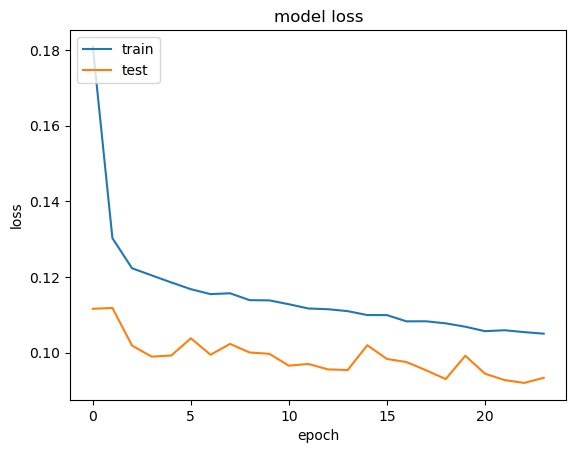

In [86]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
test_loss, test_mae, test_mba, test_rmae = model.evaluate(X_test1, y_test1)
print(f'Test MAE: {test_mae}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')

348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1055 - mae: 1.0237 - mba: 0.0661 - rmae: 117.4686
Test MAE: 1.027319073677063, Test MBA: 0.06605684012174606, Test RMAE: 116.81101989746094%


In [88]:
# from tensorflow.keras.models import load_model
# model = load_model('model_G(I)/model_all_stdscalled.keras')

342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0345 - mae: 1.0675 - mba: 0.0417 - rmae: 117.4327
Test MAE: winter, Test MBA: 0.04212445020675659, Test RMAE: 117.31865692138672%
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1451 - mae: 0.9355 - mba: 0.0775 - rmae: 111.5383
Test MAE: summer, Test MBA: 0.07776174694299698, Test RMAE: 110.7010498046875%
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0685 - mae: 1.1078 - mba: 0.0421 - rmae: 122.6875
Test MAE: spring, Test MBA: 0.04277236387133598, Test RMAE: 122.42842864990234%
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1056 - mae: 1.0749 - mba: 0.0688 - rmae: 120.6290
Test MAE: fall, Test MBA: 0.06906824558973312, Test RMAE: 120.7715072631836%


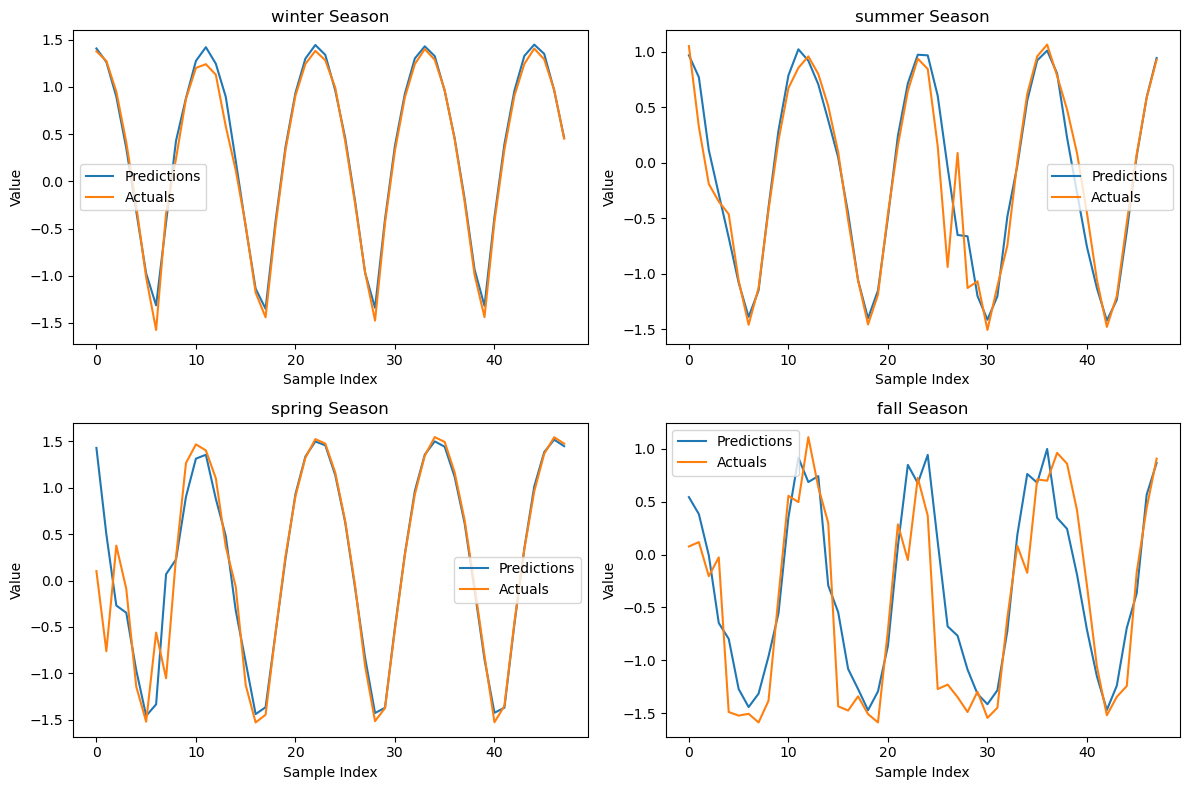

In [89]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  

for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = model.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    test_loss, test_mae, test_mba, test_rmae = model.evaluate(i, j)
    print(f'Test MAE: {season_names[idx]}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][0:48], label='Predictions')
    ax.plot(train_results['Actuals'][0:48], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()
    
    

In [92]:
# Define the more complex GRU-based model
complex_gru_model = Sequential()
complex_gru_model.add(InputLayer((5, 7)))  # Assuming input shape (24, 1)

# Add a stack of GRU layers with increasing complexity
complex_gru_model.add(GRU(128, return_sequences=True))  # First GRU layer with 128 units, returns sequences
complex_gru_model.add(Dropout(0.2))                     # Dropout for regularization
complex_gru_model.add(GRU(64, return_sequences=True))   # Second GRU layer with 64 units
complex_gru_model.add(Dropout(0.2))
complex_gru_model.add(GRU(32))                          # Final GRU layer with 32 units

# Dense layers to increase model complexity
complex_gru_model.add(Dense(16, activation='relu'))     # Dense layer with 16 units
complex_gru_model.add(Dropout(0.1))                     # Additional dropout layer
complex_gru_model.add(Dense(8, activation='relu'))      # Dense layer with 8 units

# Output layer
complex_gru_model.add(Dense(1, activation='linear'))    # Output layer for regression

# Model summary to review the structure
complex_gru_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 5, 128)         │        52,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 5, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,937 (390.38 KB)

 Trainable params: 99,937 (390.38 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Compile the model
complex_gru_model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001), 
    metrics=[mae, mba, rmae]
)

In [94]:
# Set up callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model_G(I)_Complex_GRU/model_all_stdscalled_GRU.keras', save_best_only=True)

# Model training (replace X_train1, y_train1, X_val1, y_val1 with your actual training and validation data)
history = complex_gru_model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.2217 - mae: 1.0657 - mba: 0.0811 - rmae: 120.2836 - val_loss: 0.1036 - val_mae: 1.0336 - val_mba: 0.0557 - val_rmae: 116.3734
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1074 - mae: 1.0944 - mba: 0.0523 - rmae: 123.4789 - val_loss: 0.1129 - val_mae: 1.0009 - val_mba: 0.0656 - val_rmae: 112.6353
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1013 - mae: 1.1005 - mba: 0.0504 - rmae: 123.8034 - val_loss: 0.1083 - val_mae: 1.0107 - val_mba: 0.0676 - val_rmae: 113.7144
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0967 - mae: 1.0990 - mba: 0.0496 - rmae: 123.7167 - val_loss: 0.1073 - val_mae: 1.0071 - val_mba: 0.0671 - val_rmae: 113.3638
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0956 - mae: 1.0945 - mba: 0.0468 - rmae: 123.8686 - val_loss: 0.1027 - val_mae: 1.0156 - val_mba: 0.0576 - val_rmae: 114.3122
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - 

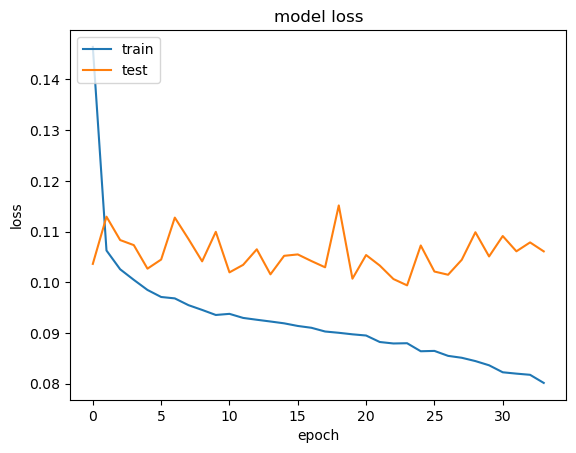

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  

for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = complex_gru_model.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    test_loss, test_mae, test_mba, test_rmae = complex_gru_model.evaluate(i, j)
    print(f'Test MAE: {season_names[idx]}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][0:250], label='Predictions')
    ax.plot(train_results['Actuals'][0:250], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Conv1D, ReLU, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define a custom Residual Block with projection to match input and output shapes
class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.relu1 = ReLU()
        self.conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.relu2 = ReLU()
        self.add = Add()
        
        # Projection layer to match input and output shapes if needed
        self.projection = Conv1D(filters=filters, kernel_size=1, padding='same') if filters != 64 else None
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.conv2(x)
        
        # Project input if necessary to match the shape
        if self.projection is not None:
            inputs = self.projection(inputs)
        
        x = self.add([inputs, x])  # Residual connection
        x = self.relu2(x)
        return x

# Define the model architecture
input_shape = (5, 7)  # Updated input shape as per your data
inputs = Input(shape=input_shape)

# LSTM Layers
x = LSTM(256, return_sequences=True)(inputs)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)

# Residual Blocks with increasing dilation rates
x = ResidualBlock(filters=128, kernel_size=3, dilation_rate=1)(x)
x = ResidualBlock(filters=128, kernel_size=3, dilation_rate=2)(x)
x = ResidualBlock(filters=128, kernel_size=3, dilation_rate=4)(x)

# Fully Connected (Dense) Layer
x = Dense(1, activation='linear')(x)  # Assuming a single output; adjust activation if needed

# Model creation
model = Model(inputs=inputs, outputs=x)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use mean squared error (mse) for regression; adjust if classification

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model_G(I)_Complex_GRU/model_all_stdscalled_GRU.keras', save_best_only=True)

# Model training (replace X_train1, y_train1, X_val1, y_val1 with your actual training and validation data)
history = model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 5, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 5, 256)         │       270,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 5, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 5, 128)         │        82,304 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 5, 128)         │       115,072 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 5, 128)         │       115,072 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 829,441 (3.16 MB)

 Trainable params: 829,441 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 1.0035 - val_loss: 1.0068
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9997 - val_loss: 1.0070
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9999 - val_loss: 1.0058
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9976 - val_loss: 1.0060
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9966 - val_loss: 1.0072
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 1.0027 - val_loss: 1.0055
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 1.0007 - val_loss: 1.0054
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 1.0042 - val_loss: 1.0055
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9964 - val_loss: 1.0054
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 1.0053 - val_loss: 1.0059
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 1.0030 - val_loss: 1.0042
Epoch 12/50
959/959 ━━━━━━━━━━

In [ ]:
print(H.history.keys())
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(11172, 5, 7)
(11172,)
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


ValueError: All arrays must be of the same length

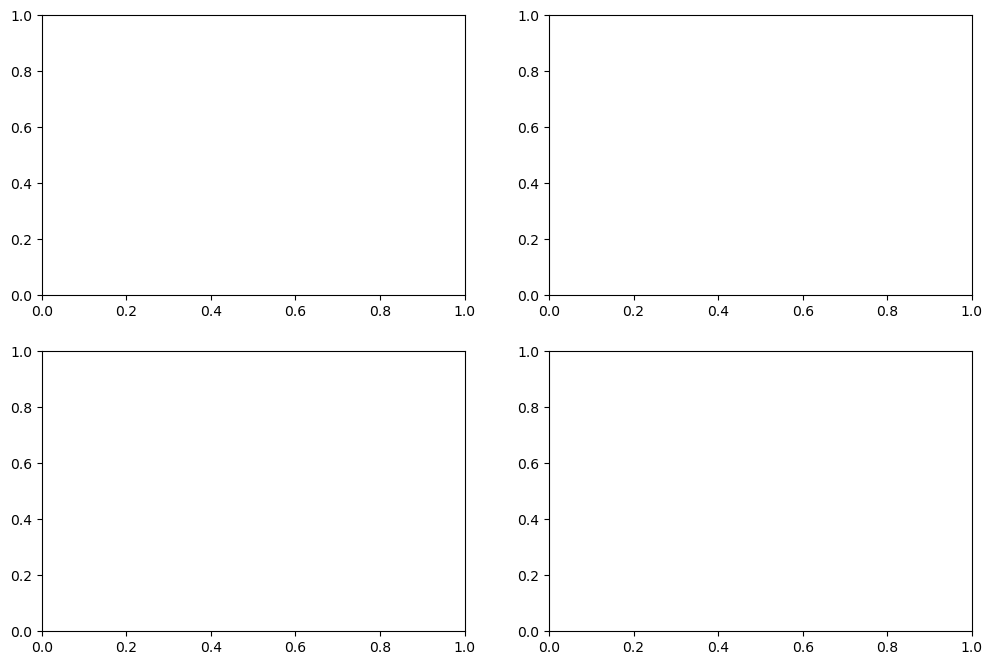

In [90]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  
print(X_fall.shape)
print(y_fall.shape)
for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = model_lstmTcn.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][0:250], label='Predictions')
    ax.plot(train_results['Actuals'][0:250], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()
    